In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from time import time

pd.set_option("display.precision", 10)

In [2]:
#Generate Data

f = lambda x: 1/(1+25*x**2)
np.random.seed(123)
n_samples = 1000
x_=np.random.uniform(-1,1,n_samples)
noise = np.random.normal(loc=0, scale=0.1, size=n_samples)
y_with_noise = f(x_) + noise
degree = 5

scalar = StandardScaler()
X = PolynomialFeatures(degree).fit_transform(x_.reshape(-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y_with_noise, test_size = 0.3)
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)
y_mean = y_train.mean()
y_train -= y_mean
y_test -= y_mean

In [3]:
# Define makers for the objectives of OLS, Ridge and Lasso
#It returns the corresponding objective: a one dimensional function
#which only depends on theta and is minimized in regression
def maker_objective_ols(X,y):
    def objective_ols(theta):
        return mean_squared_error(X @ theta, y)
    return objective_ols

def maker_objective_ridge(X, y, lmbda):
    def objective_ridge(theta):
        return mean_squared_error(X @ theta, y) + lmbda * np.sum(theta**2)
    return objective_ridge

def maker_objective_lasso(X, y, lmbda):
    def objective_lasso(theta):
        return mean_squared_error(X @ theta, y) + lmbda * np.sum(np.abs(theta))
    return objective_lasso

In [4]:
# Define the gradients for OLS, Ridge and Lasso
#For Ridge and Lasso a maker is used which takes lambda as input and returns
#the corresponding gradient
#definitions a
#Parameters of the gradients:
#xtx: np.array matrix product of X.T @ X
#xty: np.array matrix product of X.T @ y
#theta: np.array 
#n_samples: int number of samples i.e. the number of rows of X

def gradient_ols(xtx, xty, theta, n_samples):
    return 2/n_samples* (xtx @theta - xty)

def maker_gradient_ridge(lmbda):
    def gradient_ridge(xtx, xty, theta, n_samples):
        return 2/n_samples*(xtx @theta - xty) + lmbda*theta
    return gradient_ridge

def maker_gradient_lasso(lmbda):
    def gradient_lasso(xtx, xty, theta, n_samples):
        return 2/n_samples*(xtx @theta - xty) + lmbda*np.sign(theta)
    return gradient_lasso

In [5]:
#calculates the effective gradient, i.e. for non stochastic gradient the normal
#gradient with precalculated xtx and xty and for stochastic gradient random batches are created,
#the gradient for every batch is calculated and effective gradient is the average gradient of all batches
#is used in the gradient descent implementations
#parameters:
#X np.array
#y np.array
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#stochastic: boolean if stochastic gradient descent should be used
#batch_size: int used for gradient descent
def gradient_eff_calculator(X, y, gradient, stochastic, batch_size):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    if stochastic:
        def gradient_eff(theta):
            shuffled_indices = np.random.choice(range(n_samples), n_samples, replace = False)
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]
            m = int(n_samples/batch_size) # number of batches
            array_batch_gradients = np.zeros((m, n_features))
            for i in range(m):
                xi = X_shuffled[i*batch_size:(i+1)*batch_size]
                yi = y_shuffled[i*batch_size: (i+1)*batch_size] #exclude the last samples?
                batch_gradient_i = gradient(xi.T @ xi, xi.T @ yi, theta, n_samples)
                array_batch_gradients[i] = batch_gradient_i
            return np.mean(array_batch_gradients, axis = 0)
    else:
        xtx = X.T @ X
        xty = X.T @ y
        def gradient_eff(theta):
            return gradient(xtx, xty, theta, n_samples)    
    return gradient_eff



In [6]:
#generates a random initial value for the gradient decents methods
#multivariate uniform distribution where the bounds for every feature
#are the corresponding minima and maxima in X
#used in the gradient descents methods
def initial_value_generator(X):
    n_features = X.shape[1]
    return np.min(X, axis =0) + np.random.uniform(size =n_features) * (np.max(X, axis =0) - np.min(X, axis =0))

In [7]:
#calculates a normal gradient descent

#parameters:
#X: np.array features matrix
#y: np.arry targets
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#learning rate: float used for stochastic gradient descent
#max_iter: int maximum iteration number in gradient descent
#precision: float stopping criterion before iteration limit is defined as ||theta_old - theta_new||_2 <= precision
#stochastic: boolean if stochastic gradient descent should be used
#batch size: int used for stochastic gradient descent
#initial value: np.array for gradient descent, if None a random value in range of X is chosen

#returns a list containing the calculated theta and the number of used iterations
def gradient_descent_normal(X, y, gradient, learning_rate, max_iter, precision, stochastic, batch_size, initial_value = None):
    X = X.astype(np.float64)
    y = y.astype(np.float64)

    gradient_eff = gradient_eff_calculator(X, y, gradient, stochastic, batch_size)

    if initial_value is None:
        initial_value = initial_value_generator(X)
    
    theta_new = initial_value 
    theta_old = initial_value + 1
    count = 0
    while (np.linalg.norm(theta_old - theta_new, ord = None) > precision) and count < max_iter:
        theta_old = theta_new
        theta_new = theta_old - learning_rate * gradient_eff(theta_old)
        count += 1
    if(count == max_iter):
        pass #print('calculation limit exceeded')
    return [theta_new, count]

In [8]:
gradient_descent_normal(X_train, y_train, gradient_ols, learning_rate= 0.1, max_iter= 100000, precision=0.000001, stochastic=False, batch_size=100)

[array([ 0.        ,  0.00288324, -0.66867175, -0.00860772,  0.4793315 ,
         0.0045174 ]),
 6637]

In [9]:
#calculates a momentum gradient descent

#parameters:
#X: np.array features matrix
#y: np.arry targets
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#learning rate: float used for stochastic gradient descent
#max_iter: int maximum iteration number in gradient descent
#precision: float stopping criterion before iteration limit is defined as ||theta_old - theta_new||_2 <= precision
#stochastic: boolean if stochastic gradient descent should be used
#batch size: int used for stochastic gradient descent
#initial value: np.array for gradient descent, if None a random value in range of X is chosen
#momentum: float used for stochastic gradient descent

#returns a list containing the calculated theta and the number of used iterations
def gradient_descent_momentum(X, y, gradient, learning_rate, max_iter, precision, stochastic, batch_size, initial_value = None, momentum = 0.9):
    X = X.astype(np.float64)
    y = y.astype(np.float64)

    gradient_eff = gradient_eff_calculator(X, y, gradient, stochastic, batch_size)

    if initial_value is None:
        initial_value = initial_value_generator(X)
    
    theta_new = initial_value 
    theta_old = initial_value + 1
    change = 0
    count = 0
    while (np.linalg.norm(theta_old - theta_new, ord = None) > precision) and count < max_iter: 
        theta_old = theta_new
        change = learning_rate * gradient_eff(theta_old) + momentum * change
        theta_new = theta_old - change 
        count += 1
    if(count == max_iter):
        pass #print('calculation limit exceeded')
    return [theta_new, count]

In [10]:
#calculates a Adagrad gradient descent

#parameters:
#X: np.array features matrix
#y: np.arry targets
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#learning rate: float used for stochastic gradient descent
#max_iter: int maximum iteration number in gradient descent
#precision: float stopping criterion before iteration limit is defined as ||theta_old - theta_new||_2 <= precision
#stochastic: boolean if stochastic gradient descent should be used
#batch size: int used for stochastic gradient descent
#initial value: np.array for gradient descent, if None a random value in range of X is chosen
#epsilon: float used for gradient descent

#returns a list containing the calculated theta and the number of used iterations
def gradient_descent_adagrad(X, y, gradient, learning_rate, max_iter, precision, stochastic, batch_size, initial_value = None, epsilon = 1e-7):
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    n_features = X.shape[1]
    gradient_eff = gradient_eff_calculator(X, y, gradient, stochastic, batch_size)

    if initial_value is None:
        initial_value = initial_value_generator(X)
    
    theta_new = initial_value 
    theta_old = initial_value + 1
    G = np.zeros(n_features)
    gradient1 = np.zeros(n_features)
    count = 0
    while (np.linalg.norm(theta_old - theta_new, ord = None) > precision) and count < max_iter:
        theta_old = theta_new
        gradient1 = gradient_eff(theta_old)
        G = G + np.square(gradient1)
        theta_new = theta_old - learning_rate * gradient1 / np.sqrt(epsilon + G)
        count += 1
    if(count == max_iter):
        pass #print('calculation limit exceeded')
    return [theta_new, count]

In [11]:
#calculates a RMS Prop gradient descent

#parameters:
#X: np.array features matrix
#y: np.arry targets
#gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
#possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
#learning rate: float used for stochastic gradient descent
#max_iter: int maximum iteration number in gradient descent
#precision: float stopping criterion before iteration limit is defined as ||theta_old - theta_new||_2 <= precision
#stochastic: boolean if stochastic gradient descent should be used
#batch size: int used for stochastic gradient descent
#initial value: np.array for gradient descent, if None a random value in range of X is chosen
#epsilon: float used for gradient descent
#rho: float used for gradient descent

#returns a list containing the calculated theta and the number of used iterations
def gradient_descent_rmsprop(X, y, gradient, learning_rate, max_iter, precision, stochastic, batch_size, initial_value = None, epsilon = 1e-7 , rho= 0.9):
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    n_features = X.shape[1]
    gradient_eff = gradient_eff_calculator(X, y, gradient, stochastic, batch_size)

    if initial_value is None:
        initial_value = initial_value_generator(X)
        
    theta_new = initial_value 
    theta_old = initial_value + np.ones(n_features)
    v = np.zeros(n_features)
    gradient1 = np.zeros(n_features)
    count = 0
    while (np.linalg.norm(theta_old - theta_new, ord = None) > precision) and count < max_iter: 
        theta_old = theta_new
        gradient1 = gradient_eff(theta_old)
        v = rho * v + (1-rho) * gradient1**2
        theta_new = theta_old - learning_rate / np.sqrt(v + epsilon) * gradient1
        count += 1    
    
    if(count == max_iter):
        pass #print('calculation limit exceeded')
    return [theta_new, count]

**calculates a Adam gradient descent**

In [12]:
def gradient_descent_adam(X, y, gradient, learning_rate, max_iter, precision, stochastic, batch_size, initial_value = None,  epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
    """
    parameters:
    X: np.array features matrix
    y: np.arry targets
    gradient: function with parameters xtx, xty, theta and number_of samples which returns the gradient at theta as np.array
    possible functions are gradient_ols, or the returned functions of maker_gradient_ridge or maker_gradient_lasso
    learning rate: float used for stochastic gradient descent
    max_iter: int maximum iteration number in gradient descent
    precision: float stopping criterion before iteration limit is defined as ||theta_old - theta_new||_2 <= precision
    stochastic: boolean if stochastic gradient descent should be used
    batch size: int used for stochastic gradient descent
    initial value: np.array for gradient descent, if None a random value in range of X is chosen
    epsilon: float used for gradient descent
    beta_1: float used for gradient descent
    beta_2: float used for gradient descent

    returns a list containing the calculated theta and the number of used iterations
    """
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    n_features = X.shape[1]
    gradient_eff = gradient_eff_calculator(X, y, gradient, stochastic, batch_size)

    if initial_value is None:
        initial_value = initial_value_generator(X)
    
    theta_new = initial_value 
    theta_old = initial_value + np.ones(n_features)
    count = 0
    m = 0
    v = 0
    while (np.linalg.norm(theta_old - theta_new, ord = None) > precision) and count < max_iter: 
        count+=1
        theta_old = theta_new
        gradient1 = gradient_eff(theta_old)
        m = beta_1 * m + (1-beta_1)*gradient1
        v = beta_2 * v + (1-beta_2)*gradient1**2
        m_tilde = m/(1-beta_1**count)
        v_tilde = v/(1-beta_2**count)
        theta_new = theta_old - learning_rate * m_tilde / (np.sqrt(v_tilde) + epsilon)

    if(count == max_iter):
        pass #print('calculation limit exceeded')
    return [theta_new, count]

Finding the optimal learning rates via Tuning

In [13]:
warnings.filterwarnings("error", category=RuntimeWarning)
# tuning to find the best hyperparameters
# parameters:
# function: optimizer function which depends on one parameter and returns a list with the calculated optimium
# and the number of iterations, particularly the gradient descent methods are such functions if all input parameters are fixed
# apart from one hyperparameter
# parameters: list of the parameters which are possible input values for function
# objective: objective of the optimizer function, possible functions are
# objective_ols or the returned values of maker_gradient_ridge or maker_gradient_lasso
# returns:
# a list containing a Pandas DataFrame with the columns Parameters, Result Objective and Number of iterations and dictionary with the optimum for each parameter
def tuning(function, parameters, objective):
    result_objective = np.zeros(len(parameters))
    result_iterations = np.zeros(len(parameters))
    result_times = np.zeros(len(parameters))
    result_optimum = {}
    for i, parameter in enumerate(parameters):
        #print(f"test parameter {parameter}")
        try:
            start = time()
            function_run = function(parameter)
            end = time()
            result_objective[i] = objective(function_run[0])
            result_iterations[i] = function_run[1]
            result_times[i] = end - start
            result_optimum[parameter] = function_run[0]
        except RuntimeWarning:
            result_objective[i] = np.inf
            result_iterations[i] = np.inf
            #print("error")

    dataframe = pd.DataFrame({"Parameters": parameters, "Result Objective": result_objective, "Number of Iterations": result_iterations, "Time": result_times})
    return [dataframe, result_optimum]

**Gradient Descent with fixed learning rates for OLS and Ridge**

In [14]:
MAX_ITER = 1_000_000
PRECISION = 0.000001

In [15]:
function_OLS = lambda param: gradient_descent_normal(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_1 = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_ridge(10**(-1)), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_3 = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_ridge(10**(-3)), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_1 = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_lasso(10**(-1)), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_3 = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_lasso(10**(-3)), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)


parameters = np.logspace(-8, 1, num=30)


results_normal_OLS = tuning(function_OLS, parameters, maker_objective_ols(X_test, y_test))
results_normal_Ridge_1 = tuning(function_Ridge_1, parameters, maker_objective_ridge(X_test, y_test, lmbda=10**(-1)))
results_normal_Ridge_3 = tuning(function_Ridge_3, parameters, maker_objective_ridge(X_test, y_test, lmbda=10**(-3)))
results_normal_Lasso_1 = tuning(function_Lasso_1, parameters, maker_objective_lasso(X_test, y_test, lmbda=10**(-1)))
results_normal_Lasso_3 = tuning(function_Lasso_3, parameters, maker_objective_lasso(X_test, y_test, lmbda=10**(-3)))

In [16]:
df_OLS = results_normal_OLS[0]
df_ols = df_OLS[np.isfinite(df_OLS['Result Objective'])].reset_index(drop=True)

df_Ridge_1 = results_normal_Ridge_1[0]
df_ridge_1 = df_Ridge_1[np.isfinite(df_Ridge_1['Result Objective'])].reset_index(drop=True)

df_Ridge_3 = results_normal_Ridge_3[0]
df_ridge_3 = df_Ridge_3[np.isfinite(df_Ridge_3['Result Objective'])].reset_index(drop=True)

df_Lasso_1 = results_normal_Lasso_1[0]
df_lasso_1 = df_Lasso_1[np.isfinite(df_Lasso_1['Result Objective'])].reset_index(drop=True)

df_Lasso_3 = results_normal_Lasso_3[0]
df_lasso_3 = df_Lasso_3[np.isfinite(df_Lasso_3['Result Objective'])].reset_index(drop=True)

**TODO: Compare to exact solution**

In [17]:
pred_exact_OLS = LinearRegression().fit(X_train, y_train).predict(X_test)
pred_exact_Ridge_1 = Ridge(alpha=0.1).fit(X_train, y_train).predict(X_test)
pred_exact_Ridge_3 = Ridge(alpha=0.001).fit(X_train, y_train).predict(X_test)

mse_exact_OLS = mean_squared_error(y_test, pred_exact_OLS)
mse_exact_Ridge_1 = mean_squared_error(y_test, pred_exact_Ridge_1)
mse_exact_Ridge_3 = mean_squared_error(y_test, pred_exact_Ridge_3)

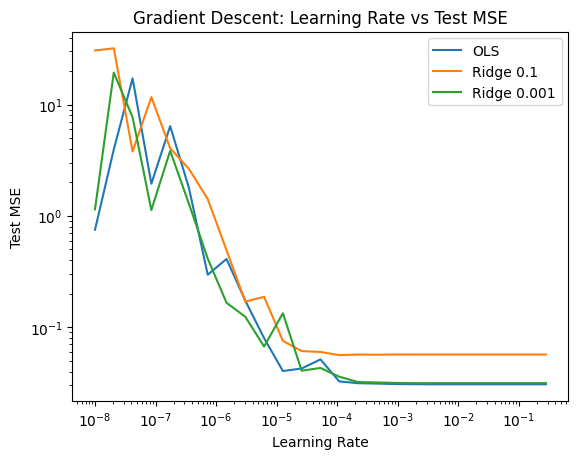

In [18]:
plt.plot(df_ols['Parameters'], df_ols['Result Objective'], label='OLS')
plt.plot(df_ridge_1['Parameters'], df_ridge_1['Result Objective'], label='Ridge 0.1')
plt.plot(df_ridge_3['Parameters'], df_ridge_3['Result Objective'], label='Ridge 0.001')

# plt.axhline(y=mse_exact_OLS, color='blue', linestyle='--', label='Exact OLS')
# plt.axhline(y=mse_exact_Ridge_1, color='orange', linestyle='--', label='Exact Ridge 0.1')
# plt.axhline(y=mse_exact_Ridge_3, color='green', linestyle='--', label='Exact Ridge 0.001')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Test MSE')
plt.title('Gradient Descent: Learning Rate vs Test MSE')
plt.legend()
plt.show()

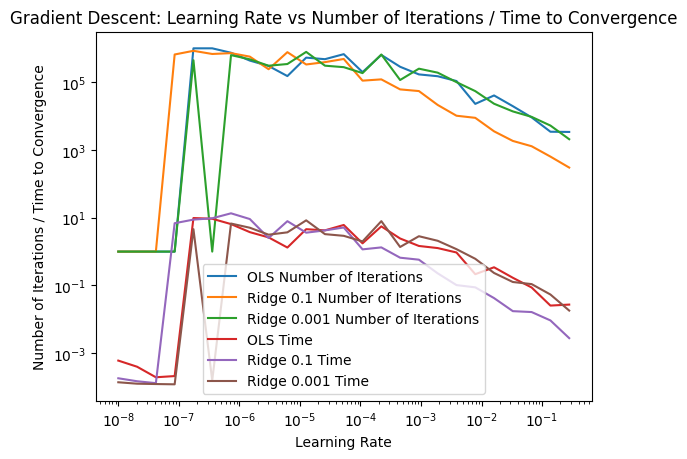

In [19]:
plt.plot(df_ols['Parameters'], df_ols['Number of Iterations'], label='OLS Number of Iterations')
plt.plot(df_ridge_1['Parameters'], df_ridge_1['Number of Iterations'], label='Ridge 0.1 Number of Iterations')
plt.plot(df_ridge_3['Parameters'], df_ridge_3['Number of Iterations'], label='Ridge 0.001 Number of Iterations')

plt.plot(df_ols['Parameters'], df_ols['Time'], label='OLS Time')
plt.plot(df_ridge_1['Parameters'], df_ridge_1['Time'], label='Ridge 0.1 Time')
plt.plot(df_ridge_3['Parameters'], df_ridge_3['Time'], label='Ridge 0.001 Time')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Iterations / Time to Convergence')
plt.title('Gradient Descent: Learning Rate vs Number of Iterations / Time to Convergence')
plt.legend()
plt.show()

**Andere Updateverfahren ohne Stochastik**

In [20]:
parameters = np.logspace(-8, 1, num=30)

In [21]:
function_OLS_normal = lambda param: gradient_descent_normal(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_normal = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_normal = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)

function_OLS_momentum = lambda param: gradient_descent_momentum(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_momentum = lambda param: gradient_descent_momentum(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_momentum = lambda param: gradient_descent_momentum(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)

function_OLS_ADAgrad = lambda param: gradient_descent_adagrad(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_ADAgrad = lambda param: gradient_descent_adagrad(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_ADAgrad = lambda param: gradient_descent_adagrad(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)

function_OLS_RMSprop = lambda param: gradient_descent_rmsprop(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_RMSprop = lambda param: gradient_descent_rmsprop(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_RMSprop = lambda param: gradient_descent_rmsprop(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)

function_OLS_Adam = lambda param: gradient_descent_adam(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Ridge_Adam = lambda param: gradient_descent_adam(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)
function_Lasso_Adam = lambda param: gradient_descent_adam(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=False, batch_size=100)



results_OLS_normal = tuning(function_OLS_normal, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_normal = tuning(function_Ridge_normal, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_normal = tuning(function_Lasso_normal, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_momentum = tuning(function_OLS_momentum, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_momentum = tuning(function_Ridge_momentum, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_momentum = tuning(function_Lasso_momentum, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_ADAgrad = tuning(function_OLS_ADAgrad, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_ADAgrad = tuning(function_Ridge_ADAgrad, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_ADAgrad = tuning(function_Lasso_ADAgrad, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_RMSprop = tuning(function_OLS_RMSprop, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_RMSprop = tuning(function_Ridge_RMSprop, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_RMSprop = tuning(function_Lasso_RMSprop, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_Adam = tuning(function_OLS_Adam, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_Adam = tuning(function_Ridge_Adam, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_Adam = tuning(function_Lasso_Adam, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

In [22]:
df_OLS_normal = results_OLS_normal[0]
df_OLS_normal = df_OLS_normal[np.isfinite(df_OLS_normal['Result Objective'])].reset_index(drop=True)
df_Ridge_normal = results_Ridge_normal[0]
df_Ridge_normal = df_Ridge_normal[np.isfinite(df_Ridge_normal['Result Objective'])].reset_index(drop=True)
df_Lasso_normal = results_Lasso_normal[0]
df_Lasso_normal = df_Lasso_normal[np.isfinite(df_Lasso_normal['Result Objective'])].reset_index(drop=True)

df_OLS_momentum = results_OLS_momentum[0]
df_OLS_momentum = df_OLS_momentum[np.isfinite(df_OLS_momentum['Result Objective'])].reset_index(drop=True)
df_Ridge_momentum = results_Ridge_momentum[0]
df_Ridge_momentum = df_Ridge_momentum[np.isfinite(df_Ridge_momentum['Result Objective'])].reset_index(drop=True)
df_Lasso_momentum = results_Lasso_momentum[0]
df_Lasso_momentum = df_Lasso_momentum[np.isfinite(df_Lasso_momentum['Result Objective'])].reset_index(drop=True)

df_OLS_ADAgrad = results_OLS_ADAgrad[0]
df_OLS_ADAgrad = df_OLS_ADAgrad[np.isfinite(df_OLS_ADAgrad['Result Objective'])].reset_index(drop=True)
df_Ridge_ADAgrad = results_Ridge_ADAgrad[0]
df_Ridge_ADAgrad = df_Ridge_ADAgrad[np.isfinite(df_Ridge_ADAgrad['Result Objective'])].reset_index(drop=True)
df_Lasso_ADAgrad = results_Lasso_ADAgrad[0]
df_Lasso_ADAgrad = df_Lasso_ADAgrad[np.isfinite(df_Lasso_ADAgrad['Result Objective'])].reset_index(drop=True)

df_OLS_RMSprop = results_OLS_RMSprop[0]
df_OLS_RMSprop = df_OLS_RMSprop[np.isfinite(df_OLS_RMSprop['Result Objective'])].reset_index(drop=True)
df_Ridge_RMSprop = results_Ridge_RMSprop[0]
df_Ridge_RMSprop = df_Ridge_RMSprop[np.isfinite(df_Ridge_RMSprop['Result Objective'])].reset_index(drop=True)
df_Lasso_RMSprop = results_Lasso_RMSprop[0]
df_Lasso_RMSprop = df_Lasso_RMSprop[np.isfinite(df_Lasso_RMSprop['Result Objective'])].reset_index(drop=True)

df_OLS_Adam = results_OLS_Adam[0]
df_OLS_Adam = df_OLS_Adam[np.isfinite(df_OLS_Adam['Result Objective'])].reset_index(drop=True)
df_Ridge_Adam = results_Ridge_Adam[0]
df_Ridge_Adam = df_Ridge_Adam[np.isfinite(df_Ridge_Adam['Result Objective'])].reset_index(drop=True)
df_Lasso_Adam = results_Lasso_Adam[0]
df_Lasso_Adam = df_Lasso_Adam[np.isfinite(df_Lasso_Adam['Result Objective'])].reset_index(drop=True)

**Andere Updateverfahren mit Stochastik**

In [23]:
function_OLS_normal_stochastic = lambda param: gradient_descent_normal(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Ridge_normal_stochastic = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Lasso_normal_stochastic = lambda param: gradient_descent_normal(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)

function_OLS_momentum_stochastic = lambda param: gradient_descent_momentum(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Ridge_momentum_stochastic = lambda param: gradient_descent_momentum(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Lasso_momentum_stochastic = lambda param: gradient_descent_momentum(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)

function_OLS_ADAgrad_stochastic = lambda param: gradient_descent_adagrad(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Ridge_ADAgrad_stochastic = lambda param: gradient_descent_adagrad(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Lasso_ADAgrad_stochastic = lambda param: gradient_descent_adagrad(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)

function_OLS_RMSprop_stochastic = lambda param: gradient_descent_rmsprop(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Ridge_RMSprop_stochastic = lambda param: gradient_descent_rmsprop(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Lasso_RMSprop_stochastic = lambda param: gradient_descent_rmsprop(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)

function_OLS_Adam_stochastic = lambda param: gradient_descent_adam(X_train, y_train, gradient_ols, learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Ridge_Adam_stochastic = lambda param: gradient_descent_adam(X_train, y_train, maker_gradient_ridge(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)
function_Lasso_Adam_stochastic = lambda param: gradient_descent_adam(X_train, y_train, maker_gradient_lasso(0.1), learning_rate=param, max_iter=MAX_ITER, precision=PRECISION, stochastic=True, batch_size=100)




results_OLS_normal_stochastic = tuning(function_OLS_normal_stochastic, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_normal_stochastic = tuning(function_Ridge_normal_stochastic, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_normal_stochastic = tuning(function_Lasso_normal_stochastic, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_momentum_stochastic = tuning(function_OLS_momentum_stochastic, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_momentum_stochastic = tuning(function_Ridge_momentum_stochastic, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_momentum_stochastic = tuning(function_Lasso_momentum_stochastic, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_ADAgrad_stochastic = tuning(function_OLS_ADAgrad_stochastic, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_ADAgrad_stochastic = tuning(function_Ridge_ADAgrad_stochastic, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_ADAgrad_stochastic = tuning(function_Lasso_ADAgrad_stochastic, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_RMSprop_stochastic = tuning(function_OLS_RMSprop_stochastic, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_RMSprop_stochastic = tuning(function_Ridge_RMSprop_stochastic, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_RMSprop_stochastic = tuning(function_Lasso_RMSprop_stochastic, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

results_OLS_Adam_stochastic = tuning(function_OLS_Adam_stochastic, parameters, maker_objective_ols(X_train, y_train))
results_Ridge_Adam_stochastic = tuning(function_Ridge_Adam_stochastic, parameters, maker_objective_ridge(X_train, y_train, lmbda=0.1))
results_Lasso_Adam_stochastic = tuning(function_Lasso_Adam_stochastic, parameters, maker_objective_lasso(X_train, y_train, lmbda=0.1))

In [24]:
df_OLS_normal_stochastic = results_OLS_normal_stochastic[0]
df_OLS_normal_stochastic = df_OLS_normal_stochastic[np.isfinite(df_OLS_normal_stochastic['Result Objective'])].reset_index(drop=True)
df_Ridge_normal_stochastic = results_Ridge_normal_stochastic[0]
df_Ridge_normal_stochastic = df_Ridge_normal_stochastic[np.isfinite(df_Ridge_normal_stochastic['Result Objective'])].reset_index(drop=True)
df_Lasso_normal_stochastic = results_Lasso_normal_stochastic[0]
df_Lasso_normal_stochastic = df_Lasso_normal_stochastic[np.isfinite(df_Lasso_normal_stochastic['Result Objective'])].reset_index(drop=True)

df_OLS_momentum_stochastic = results_OLS_momentum_stochastic[0]
df_OLS_momentum_stochastic = df_OLS_momentum_stochastic[np.isfinite(df_OLS_momentum_stochastic['Result Objective'])].reset_index(drop=True)
df_Ridge_momentum_stochastic = results_Ridge_momentum_stochastic[0]
df_Ridge_momentum_stochastic = df_Ridge_momentum_stochastic[np.isfinite(df_Ridge_momentum_stochastic['Result Objective'])].reset_index(drop=True)
df_Lasso_momentum_stochastic = results_Lasso_momentum_stochastic[0]
df_Lasso_momentum_stochastic = df_Lasso_momentum_stochastic[np.isfinite(df_Lasso_momentum_stochastic['Result Objective'])].reset_index(drop=True)

df_OLS_ADAgrad_stochastic = results_OLS_ADAgrad_stochastic[0]
df_OLS_ADAgrad_stochastic = df_OLS_ADAgrad_stochastic[np.isfinite(df_OLS_ADAgrad_stochastic['Result Objective'])].reset_index(drop=True)
df_Ridge_ADAgrad_stochastic = results_Ridge_ADAgrad_stochastic[0]
df_Ridge_ADAgrad_stochastic = df_Ridge_ADAgrad_stochastic[np.isfinite(df_Ridge_ADAgrad_stochastic['Result Objective'])].reset_index(drop=True)
df_Lasso_ADAgrad_stochastic = results_Lasso_ADAgrad_stochastic[0]
df_Lasso_ADAgrad_stochastic = df_Lasso_ADAgrad_stochastic[np.isfinite(df_Lasso_ADAgrad_stochastic['Result Objective'])].reset_index(drop=True)

df_OLS_RMSprop_stochastic = results_OLS_RMSprop_stochastic[0]
df_OLS_RMSprop_stochastic = df_OLS_RMSprop_stochastic[np.isfinite(df_OLS_RMSprop_stochastic['Result Objective'])].reset_index(drop=True)
df_Ridge_RMSprop_stochastic = results_Ridge_RMSprop_stochastic[0]
df_Ridge_RMSprop_stochastic = df_Ridge_RMSprop_stochastic[np.isfinite(df_Ridge_RMSprop_stochastic['Result Objective'])].reset_index(drop=True)
df_Lasso_RMSprop_stochastic = results_Lasso_RMSprop_stochastic[0]
df_Lasso_RMSprop_stochastic = df_Lasso_RMSprop_stochastic[np.isfinite(df_Lasso_RMSprop_stochastic['Result Objective'])].reset_index(drop=True)

df_OLS_Adam_stochastic = results_OLS_Adam_stochastic[0]
df_OLS_Adam_stochastic = df_OLS_Adam_stochastic[np.isfinite(df_OLS_Adam_stochastic['Result Objective'])].reset_index(drop=True)
df_Ridge_Adam_stochastic = results_Ridge_Adam_stochastic[0]
df_Ridge_Adam_stochastic = df_Ridge_Adam_stochastic[np.isfinite(df_Ridge_Adam_stochastic['Result Objective'])].reset_index(drop=True)
df_Lasso_Adam_stochastic = results_Lasso_Adam_stochastic[0]
df_Lasso_Adam_stochastic = df_Lasso_Adam_stochastic[np.isfinite(df_Lasso_Adam_stochastic['Result Objective'])].reset_index(drop=True)

**Results**

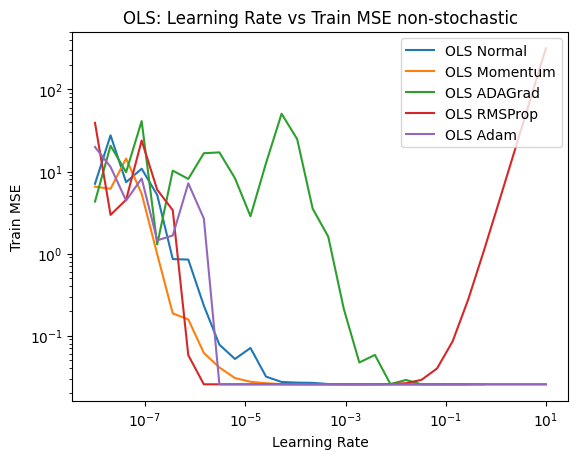

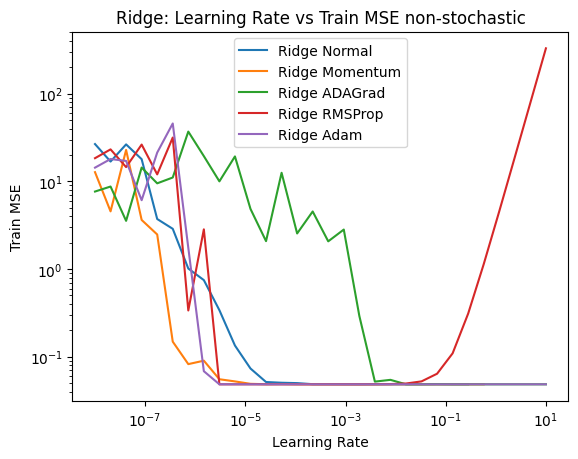

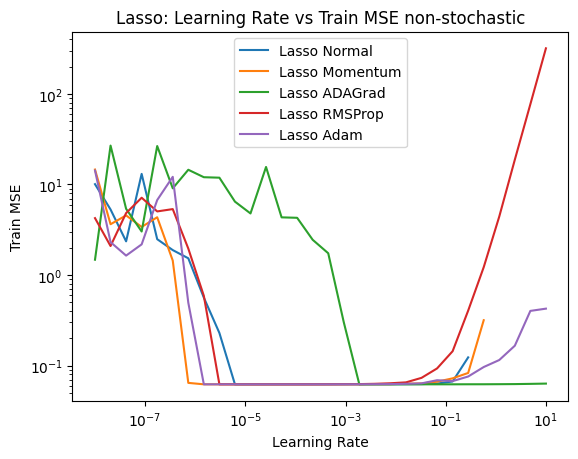

In [25]:
plt.plot(df_OLS_normal['Parameters'], df_OLS_normal['Result Objective'], label='OLS Normal')
plt.plot(df_OLS_momentum['Parameters'], df_OLS_momentum['Result Objective'], label='OLS Momentum')
plt.plot(df_OLS_ADAgrad['Parameters'], df_OLS_ADAgrad['Result Objective'], label='OLS ADAGrad')
plt.plot(df_OLS_RMSprop['Parameters'], df_OLS_RMSprop['Result Objective'], label='OLS RMSProp')
plt.plot(df_OLS_Adam['Parameters'], df_OLS_Adam['Result Objective'], label='OLS Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('OLS: Learning Rate vs Train MSE non-stochastic')
plt.legend()
plt.show()


plt.plot(df_Ridge_normal['Parameters'], df_Ridge_normal['Result Objective'], label='Ridge Normal')
plt.plot(df_Ridge_momentum['Parameters'], df_Ridge_momentum['Result Objective'], label='Ridge Momentum')
plt.plot(df_Ridge_ADAgrad['Parameters'], df_Ridge_ADAgrad['Result Objective'], label='Ridge ADAGrad')
plt.plot(df_Ridge_RMSprop['Parameters'], df_Ridge_RMSprop['Result Objective'], label='Ridge RMSProp')
plt.plot(df_Ridge_Adam['Parameters'], df_Ridge_Adam['Result Objective'], label='Ridge Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('Ridge: Learning Rate vs Train MSE non-stochastic')
plt.legend()
plt.show()


plt.plot(df_Lasso_normal['Parameters'], df_Lasso_normal['Result Objective'], label='Lasso Normal')
plt.plot(df_Lasso_momentum['Parameters'], df_Lasso_momentum['Result Objective'], label='Lasso Momentum')
plt.plot(df_Lasso_ADAgrad['Parameters'], df_Lasso_ADAgrad['Result Objective'], label='Lasso ADAGrad')
plt.plot(df_Lasso_RMSprop['Parameters'], df_Lasso_RMSprop['Result Objective'], label='Lasso RMSProp')
plt.plot(df_Lasso_Adam['Parameters'], df_Lasso_Adam['Result Objective'], label='Lasso Adam')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('Lasso: Learning Rate vs Train MSE non-stochastic')
plt.legend()
plt.show()

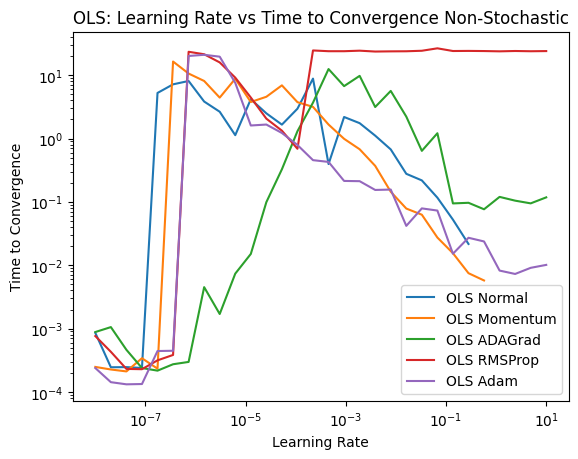

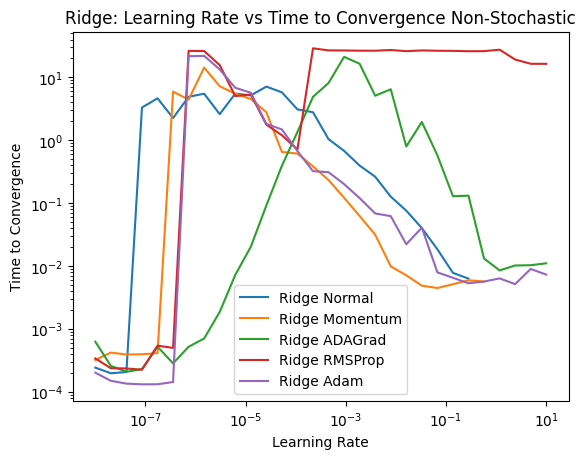

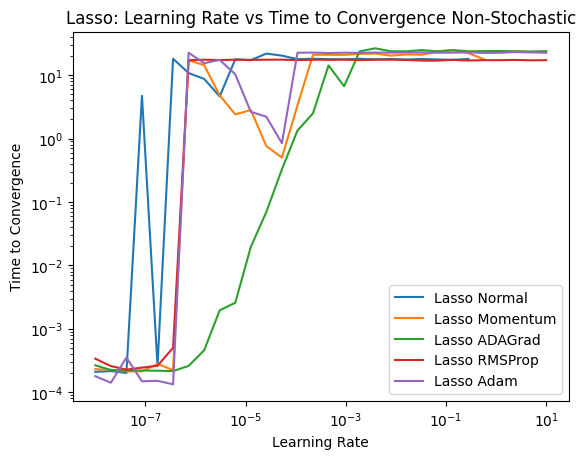

In [26]:
plt.plot(df_OLS_normal['Parameters'], df_OLS_normal['Time'], label='OLS Normal')
plt.plot(df_OLS_momentum['Parameters'], df_OLS_momentum['Time'], label='OLS Momentum')
plt.plot(df_OLS_ADAgrad['Parameters'], df_OLS_ADAgrad['Time'], label='OLS ADAGrad')
plt.plot(df_OLS_RMSprop['Parameters'], df_OLS_RMSprop['Time'], label='OLS RMSProp')
plt.plot(df_OLS_Adam['Parameters'], df_OLS_Adam['Time'], label='OLS Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('OLS: Learning Rate vs Time to Convergence Non-Stochastic')
plt.legend()
plt.show()


plt.plot(df_Ridge_normal['Parameters'], df_Ridge_normal['Time'], label='Ridge Normal')
plt.plot(df_Ridge_momentum['Parameters'], df_Ridge_momentum['Time'], label='Ridge Momentum')
plt.plot(df_Ridge_ADAgrad['Parameters'], df_Ridge_ADAgrad['Time'], label='Ridge ADAGrad')
plt.plot(df_Ridge_RMSprop['Parameters'], df_Ridge_RMSprop['Time'], label='Ridge RMSProp')
plt.plot(df_Ridge_Adam['Parameters'], df_Ridge_Adam['Time'], label='Ridge Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('Ridge: Learning Rate vs Time to Convergence Non-Stochastic')
plt.legend()
plt.show()


plt.plot(df_Lasso_normal['Parameters'], df_Lasso_normal['Time'], label='Lasso Normal')
plt.plot(df_Lasso_momentum['Parameters'], df_Lasso_momentum['Time'], label='Lasso Momentum')
plt.plot(df_Lasso_ADAgrad['Parameters'], df_Lasso_ADAgrad['Time'], label='Lasso ADAGrad')
plt.plot(df_Lasso_RMSprop['Parameters'], df_Lasso_RMSprop['Time'], label='Lasso RMSProp')
plt.plot(df_Lasso_Adam['Parameters'], df_Lasso_Adam['Time'], label='Lasso Adam')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('Lasso: Learning Rate vs Time to Convergence Non-Stochastic')
plt.legend()
plt.show()

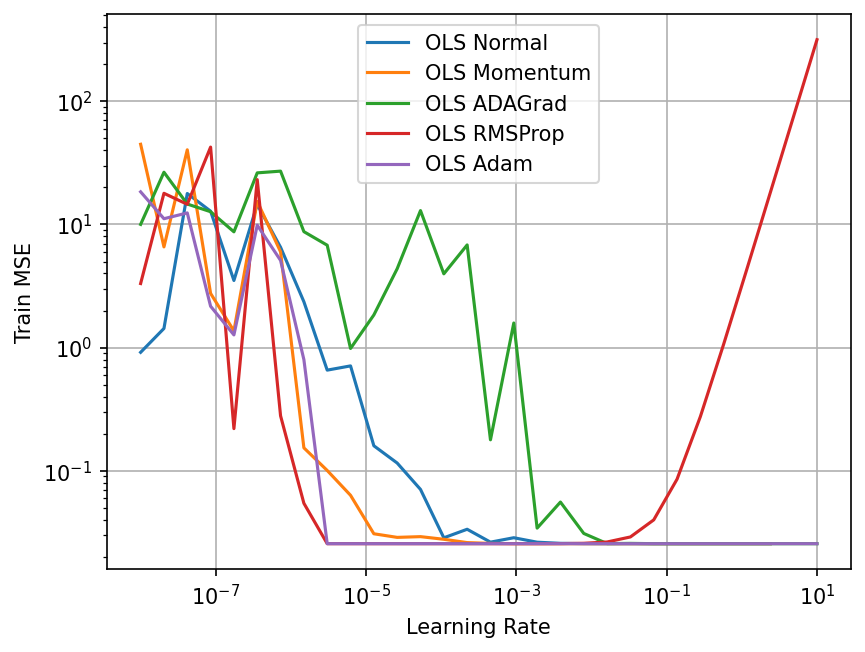

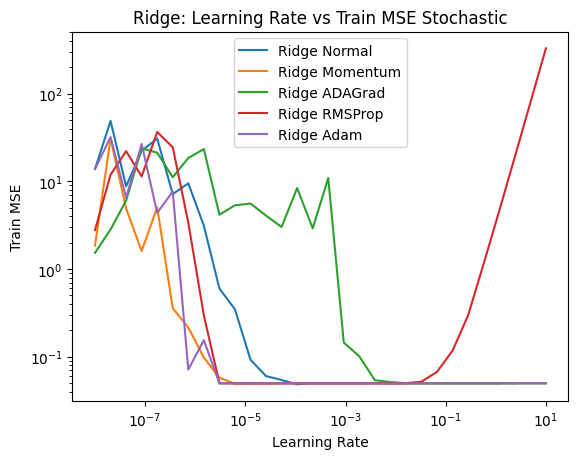

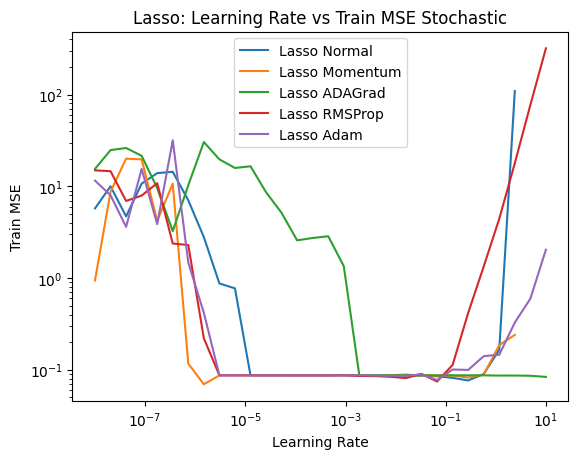

In [36]:
# Report

plt.figure(dpi=150)
plt.plot(df_OLS_normal_stochastic['Parameters'], df_OLS_normal_stochastic['Result Objective'], label='OLS Normal')
plt.plot(df_OLS_momentum_stochastic['Parameters'], df_OLS_momentum_stochastic['Result Objective'], label='OLS Momentum')
plt.plot(df_OLS_ADAgrad_stochastic['Parameters'], df_OLS_ADAgrad_stochastic['Result Objective'], label='OLS ADAGrad')
plt.plot(df_OLS_RMSprop_stochastic['Parameters'], df_OLS_RMSprop_stochastic['Result Objective'], label='OLS RMSProp')
plt.plot(df_OLS_Adam_stochastic['Parameters'], df_OLS_Adam_stochastic['Result Objective'], label='OLS Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.grid()
# plt.title('OLS: Learning Rate vs Train MSE Stochastic')
plt.legend()
plt.show()


plt.plot(df_Ridge_normal_stochastic['Parameters'], df_Ridge_normal_stochastic['Result Objective'], label='Ridge Normal')
plt.plot(df_Ridge_momentum_stochastic['Parameters'], df_Ridge_momentum_stochastic['Result Objective'], label='Ridge Momentum')
plt.plot(df_Ridge_ADAgrad_stochastic['Parameters'], df_Ridge_ADAgrad_stochastic['Result Objective'], label='Ridge ADAGrad')
plt.plot(df_Ridge_RMSprop_stochastic['Parameters'], df_Ridge_RMSprop_stochastic['Result Objective'], label='Ridge RMSProp')
plt.plot(df_Ridge_Adam_stochastic['Parameters'], df_Ridge_Adam_stochastic['Result Objective'], label='Ridge Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('Ridge: Learning Rate vs Train MSE Stochastic')
plt.legend()
plt.show()


plt.plot(df_Lasso_normal_stochastic['Parameters'], df_Lasso_normal_stochastic['Result Objective'], label='Lasso Normal')
plt.plot(df_Lasso_momentum_stochastic['Parameters'], df_Lasso_momentum_stochastic['Result Objective'], label='Lasso Momentum')
plt.plot(df_Lasso_ADAgrad_stochastic['Parameters'], df_Lasso_ADAgrad_stochastic['Result Objective'], label='Lasso ADAGrad')
plt.plot(df_Lasso_RMSprop_stochastic['Parameters'], df_Lasso_RMSprop_stochastic['Result Objective'], label='Lasso RMSProp')
plt.plot(df_Lasso_Adam_stochastic['Parameters'], df_Lasso_Adam_stochastic['Result Objective'], label='Lasso Adam')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train MSE')
plt.title('Lasso: Learning Rate vs Train MSE Stochastic')
plt.legend()
plt.show()

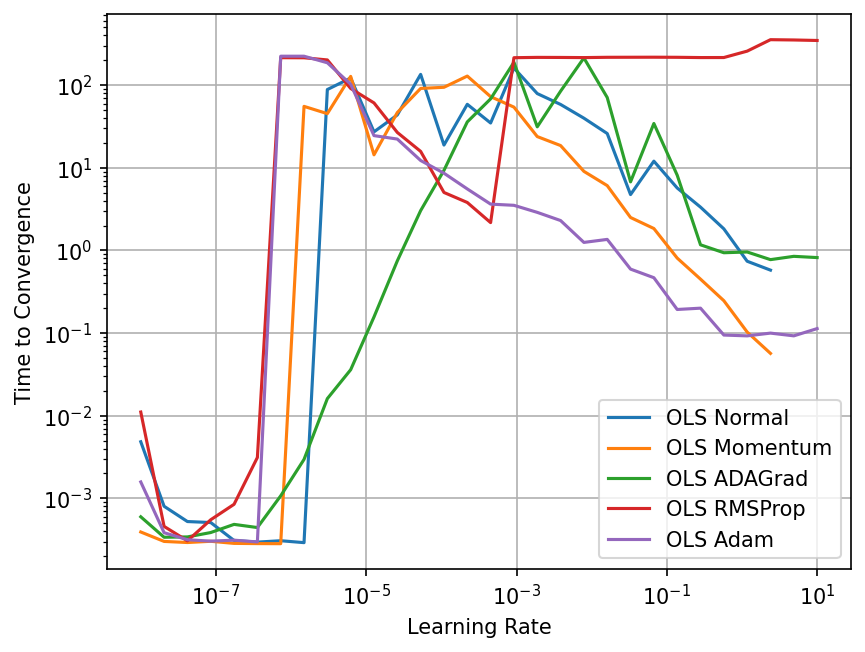

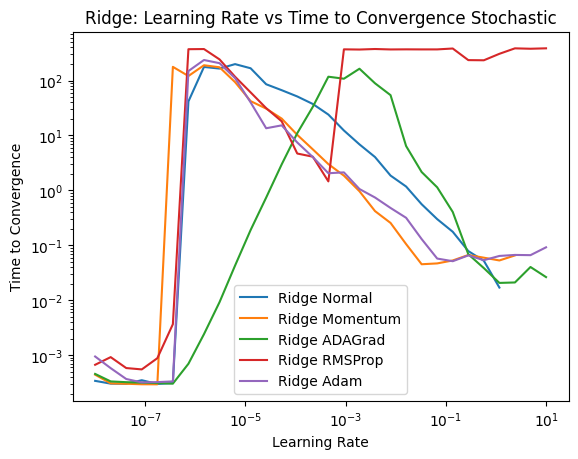

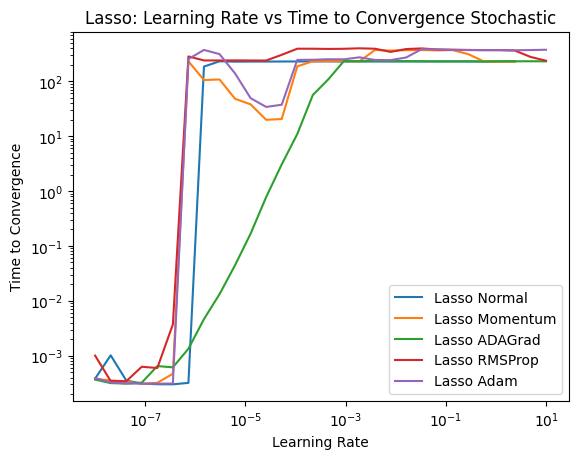

In [34]:
# Report

plt.figure(dpi=150)
plt.plot(df_OLS_normal_stochastic['Parameters'], df_OLS_normal_stochastic['Time'], label='OLS Normal')
plt.plot(df_OLS_momentum_stochastic['Parameters'], df_OLS_momentum_stochastic['Time'], label='OLS Momentum')
plt.plot(df_OLS_ADAgrad_stochastic['Parameters'], df_OLS_ADAgrad_stochastic['Time'], label='OLS ADAGrad')
plt.plot(df_OLS_RMSprop_stochastic['Parameters'], df_OLS_RMSprop_stochastic['Time'], label='OLS RMSProp')
plt.plot(df_OLS_Adam_stochastic['Parameters'], df_OLS_Adam_stochastic['Time'], label='OLS Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.grid()
# plt.title('OLS: Learning Rate vs Time to Convergence Stochastic')
plt.legend()
plt.show()


plt.plot(df_Ridge_normal_stochastic['Parameters'], df_Ridge_normal_stochastic['Time'], label='Ridge Normal')
plt.plot(df_Ridge_momentum_stochastic['Parameters'], df_Ridge_momentum_stochastic['Time'], label='Ridge Momentum')
plt.plot(df_Ridge_ADAgrad_stochastic['Parameters'], df_Ridge_ADAgrad_stochastic['Time'], label='Ridge ADAGrad')
plt.plot(df_Ridge_RMSprop_stochastic['Parameters'], df_Ridge_RMSprop_stochastic['Time'], label='Ridge RMSProp')
plt.plot(df_Ridge_Adam_stochastic['Parameters'], df_Ridge_Adam_stochastic['Time'], label='Ridge Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('Ridge: Learning Rate vs Time to Convergence Stochastic')
plt.legend()
plt.show()


plt.plot(df_Lasso_normal_stochastic['Parameters'], df_Lasso_normal_stochastic['Time'], label='Lasso Normal')
plt.plot(df_Lasso_momentum_stochastic['Parameters'], df_Lasso_momentum_stochastic['Time'], label='Lasso Momentum')
plt.plot(df_Lasso_ADAgrad_stochastic['Parameters'], df_Lasso_ADAgrad_stochastic['Time'], label='Lasso ADAGrad')
plt.plot(df_Lasso_RMSprop_stochastic['Parameters'], df_Lasso_RMSprop_stochastic['Time'], label='Lasso RMSProp')
plt.plot(df_Lasso_Adam_stochastic['Parameters'], df_Lasso_Adam_stochastic['Time'], label='Lasso Adam')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time to Convergence')
plt.title('Lasso: Learning Rate vs Time to Convergence Stochastic')
plt.legend()
plt.show()

In [41]:
print(max(df_OLS_normal_stochastic["Parameters"]))
print(max(df_OLS_momentum_stochastic["Parameters"]))
print(max(df_OLS_ADAgrad_stochastic["Parameters"]))
print(max(df_OLS_RMSprop_stochastic["Parameters"]))
print(max(df_OLS_Adam_stochastic["Parameters"]))

2.395026619987491
2.395026619987491
10.0
10.0
10.0


**Plots for report**

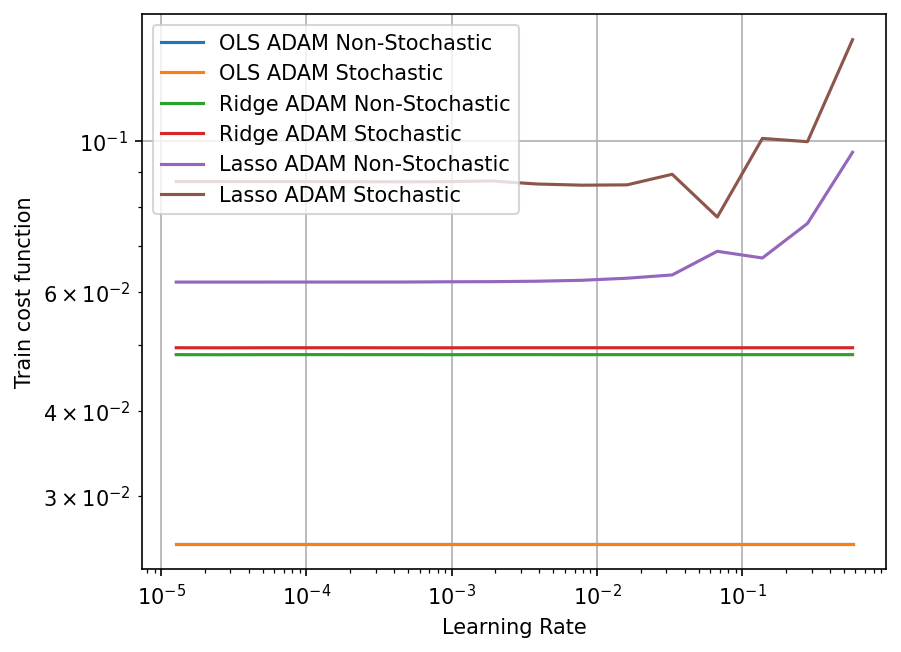

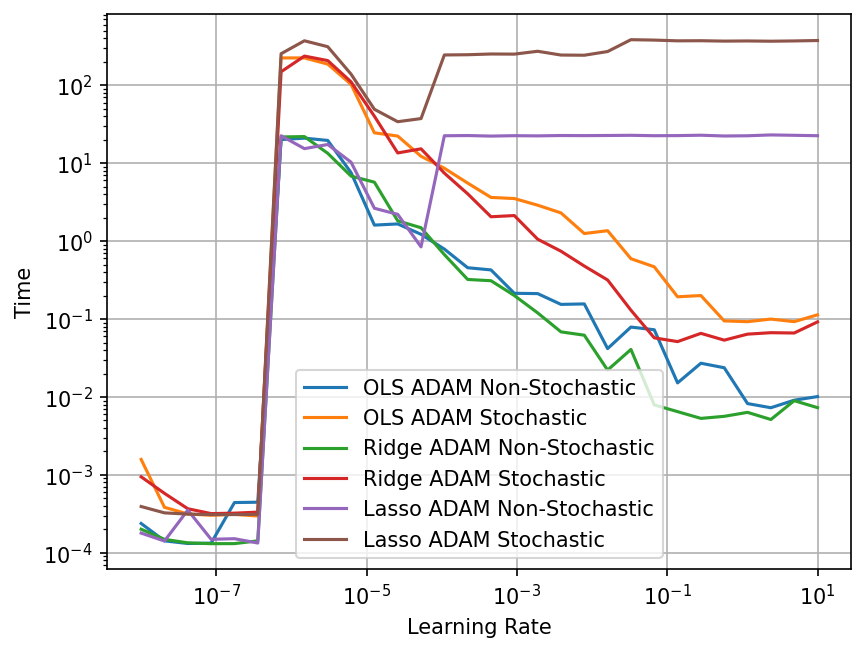

In [35]:
FILTER_LOW = 1e-5
FILTER_HIGH = 1e+0

OLS = True
RIDGE = True
LASSO = True

plt.figure(dpi=150)

if OLS:
    plt.plot(df_OLS_Adam.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Parameters'], df_OLS_Adam.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Result Objective'], label='OLS ADAM Non-Stochastic')
    plt.plot(df_OLS_Adam_stochastic.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Parameters'], df_OLS_Adam_stochastic.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Result Objective'], label='OLS ADAM Stochastic')

if RIDGE:
    plt.plot(df_Ridge_Adam.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Parameters'], df_Ridge_Adam.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Result Objective'], label='Ridge ADAM Non-Stochastic')
    plt.plot(df_Ridge_Adam_stochastic.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Parameters'], df_Ridge_Adam_stochastic.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Result Objective'], label='Ridge ADAM Stochastic')

if LASSO:
    plt.plot(df_Lasso_Adam.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Parameters'], df_Lasso_Adam.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Result Objective'], label='Lasso ADAM Non-Stochastic')
    plt.plot(df_Lasso_Adam_stochastic.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Parameters'], df_Lasso_Adam_stochastic.query("@FILTER_LOW < Parameters < @FILTER_HIGH")['Result Objective'], label='Lasso ADAM Stochastic')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Train cost function')
plt.grid()
# plt.title('Learning Rate vs Train cost function ADAM')
plt.legend()
plt.show()

plt.figure(dpi=150)

if OLS:
    plt.plot(df_OLS_Adam['Parameters'], df_OLS_Adam['Time'], label='OLS ADAM Non-Stochastic')
    plt.plot(df_OLS_Adam_stochastic['Parameters'], df_OLS_Adam_stochastic['Time'], label='OLS ADAM Stochastic')

if RIDGE:
    plt.plot(df_Ridge_Adam['Parameters'], df_Ridge_Adam['Time'], label='Ridge ADAM Non-Stochastic')
    plt.plot(df_Ridge_Adam_stochastic['Parameters'], df_Ridge_Adam_stochastic['Time'], label='Ridge ADAM Stochastic')

if LASSO:
    plt.plot(df_Lasso_Adam['Parameters'], df_Lasso_Adam['Time'], label='Lasso ADAM Non-Stochastic')
    plt.plot(df_Lasso_Adam_stochastic['Parameters'], df_Lasso_Adam_stochastic['Time'], label='Lasso ADAM Stochastic')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Time')
plt.grid()
# plt.title('Learning Rate vs Time to Convergence ADAM')
plt.legend()
plt.show()

**Finding optimal learning rates via Tuning**

In [30]:
results_Lasso_Adam_stochastic[0].sort_values(by='Result Objective')

,Parameters,Result Objective,Number of Iterations,Time
22,0.0672335754,0.0772687526,1000000.0,379.9024457932
19,0.0078804628,0.0860803528,1000000.0,242.8596551418
20,0.0161026203,0.0861755607,1000000.0,270.9191620350
18,0.0038566204,0.0864226680,1000000.0,244.2134652138
15,0.0004520354,0.0870608808,1000000.0,251.9018237591
14,0.0002212216,0.0871075030,1000000.0,246.4683797359
16,0.0009236709,0.0871075595,1000000.0,250.9126341343
13,0.0001082637,0.0871287522,1000000.0,244.8203330040
12,0.0000529832,0.0871357347,143676.0,37.3672475815
8,0.0000030392,0.0871367908,899531.0,312.5021784306


**Optimale Learningrate**

OLS Normal non-stochastic: 0.1, 7
Ridge Normal non-stochastic: 0.1, 7
Lasso Normal non-stochastic: 0.00001, 3

OLS Momentum non-stochastic: 0.1, 7
Ridge Momentum non-stochastic: 0.1, 7
Lasso Momentum non-stochastic: 0.0001, 4

OLS ADAgrad non-stochastic: 1.0, 8
Ridge ADAgrad non-stochastic: 1.0, 8
Lasso ADAgrad non-stochastic: 0.01, 6

OLS RMSprop non-stochastic: 0.0001, 4
Ridge RMSprop non-stochastic: 0.0001, 4
Lasso RMSprop non-stochastic: 0.000001, 2

OLS Adam non-stochastic: 1.0, 8
Ridge Adam non-stochastic: 0.1, 7
Lasso Adam non-stochastic: 0.00001, 3



OLS Normal stochastic: 1.0, 8
Ridge Normal stochastic: 1.0, 8
Lasso Normal stochastic: 0.01, 6

OLS Momentum stochastic: 1.0, 8
Ridge Momentum stochastic: 1.0, 8
Lasso Momentum stochastic: 0.1, 7

OLS ADAgrad stochastic: 1.0, 8
Ridge ADAgrad stochastic: 10.0, 9
Lasso ADAgrad stochastic: 10.0, 9

OLS RMSprop stochastic: 0.0001, 4
Ridge RMSprop stochastic: 0.0001, 4
Lasso RMSprop stochastic: 0.01, 6

OLS Adam stochastic: 0.1, 7
Ridge Adam stochastic: 1.0, 8
Lasso Adam stochastic: 0.1, 7

In [31]:
results_OLS = [results_OLS_normal, results_OLS_momentum, results_OLS_ADAgrad, results_OLS_RMSprop, results_OLS_Adam, results_OLS_normal_stochastic, results_OLS_momentum_stochastic, results_OLS_ADAgrad_stochastic, results_OLS_RMSprop_stochastic, results_OLS_Adam_stochastic]
results_Ridge = [results_Ridge_normal, results_Ridge_momentum, results_Ridge_ADAgrad, results_Ridge_RMSprop, results_Ridge_Adam, results_Ridge_normal_stochastic, results_Ridge_momentum_stochastic, results_Ridge_ADAgrad_stochastic, results_Ridge_RMSprop_stochastic, results_Ridge_Adam_stochastic]
results_Lasso = [results_Lasso_normal, results_Lasso_momentum, results_Lasso_ADAgrad, results_Lasso_RMSprop, results_Lasso_Adam, results_Lasso_normal_stochastic, results_Lasso_momentum_stochastic, results_Lasso_ADAgrad_stochastic, results_Lasso_RMSprop_stochastic, results_Lasso_Adam_stochastic]
table = lambda: [
    ["normal non-stoch", 7, 7, 3],
    ["momentum non-stoch", 7, 7, 4],
    ["ADAGrad non-stoch", 8, 8, 6],
    ["RMSProp non-stoch", 4, 4, 2],
    ["Adam non-stoch", 8, 7, 3],

    ["normal stoch", 8, 8, 6],
    ["momentum stoch", 8, 8, 7],
    ["ADAGrad stoch", 8, 9, 9],
    ["RMSProp stoch", 4, 4, 6],
    ["Adam stoch", 7, 8, 7],
]

print("OLS:")
print("\hline OLS & Train & Test & Time \\\ \hline")
for idx, line in enumerate(table()):
    line.append(maker_objective_ols(X_train, y_train)(results_OLS[idx][1][parameters[line[1]]]))
    line.append(maker_objective_ols(X_test, y_test)(results_OLS[idx][1][parameters[line[1]]]))
    line.append(results_OLS[idx][0]['Time'][line[1]])

    print("".join([line[0]] + [f" & {line[i+4]:.4e}" for i in range(3)] + [" \\\ \hline"]))

print("\nRidge:")
print("\hline Ridge & Train & Test & Time \\\ \hline")
for idx, line in enumerate(table()):
    line.append(maker_objective_ridge(X_train, y_train, lmbda=parameters[line[2]])(results_Ridge[idx][1][parameters[line[2]]]))
    line.append(maker_objective_ridge(X_test, y_test, lmbda=parameters[line[2]])(results_Ridge[idx][1][parameters[line[2]]]))
    line.append(results_Ridge[idx][0]['Time'][line[2]])

    print("".join([line[0]] + [f" & {line[i+4]:.4e}" for i in range(3)] + [" \\\ \hline"]))

print("\nLasso:")
print("\hline Lasso & Train & Test & Time \\\ \hline")
for idx, line in enumerate(table()):
    line.append(maker_objective_lasso(X_train, y_train, lmbda=parameters[line[3]])(results_Lasso[idx][1][parameters[line[3]]]))
    line.append(maker_objective_lasso(X_test, y_test, lmbda=parameters[line[3]])(results_Lasso[idx][1][parameters[line[3]]]))
    line.append(results_Lasso[idx][0]['Time'][line[3]])

    print("".join([line[0]] + [f" & {line[i+4]:.4e}" for i in range(3)] + [" \\\ \hline"]))

OLS:
\hline OLS & Train & Test & Time \\ \hline
normal non-stoch & 2.3208e-01 & 2.3566e-01 & 3.8344e+00 \\ \hline
momentum non-stoch & 6.1503e-02 & 6.1593e-02 & 8.0973e+00 \\ \hline
ADAGrad non-stoch & 1.7098e+01 & 1.5177e+01 & 1.6985e-03 \\ \hline
RMSProp non-stoch & 6.0012e+00 & 5.4516e+00 & 3.1519e-04 \\ \hline
Adam non-stoch & 2.5538e-02 & 3.0706e-02 & 1.9590e+01 \\ \hline
normal stoch & 6.5584e-01 & 5.8718e-01 & 8.8591e+01 \\ \hline
momentum stoch & 1.0042e-01 & 1.1536e-01 & 4.5260e+01 \\ \hline
ADAGrad stoch & 6.7826e+00 & 6.1723e+00 & 1.6102e-02 \\ \hline
RMSProp stoch & 2.1964e-01 & 2.1802e-01 & 8.4734e-04 \\ \hline
Adam stoch & 7.9838e-01 & 7.8953e-01 & 2.2432e+02 \\ \hline

Ridge:
\hline Ridge & Train & Test & Time \\ \hline
normal non-stoch & 3.7801e-01 & 3.6431e-01 & 5.4997e+00 \\ \hline
momentum non-stoch & 3.0932e-02 & 3.8794e-02 & 1.4297e+01 \\ \hline
ADAGrad non-stoch & 9.1549e+00 & 8.7612e+00 & 1.8561e-03 \\ \hline
RMSProp non-stoch & 1.0922e+01 & 1.0114e+01 & 5.3954e-

<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:25: SyntaxWarning: invalid escape sequence '\ '
<>:28: SyntaxWarning: invalid escape sequence '\h'
<>:34: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\h'
<>:43: SyntaxWarning: invalid escape sequence '\ '
<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:25: SyntaxWarning: invalid escape sequence '\ '
<>:28: SyntaxWarning: invalid escape sequence '\h'
<>:34: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\h'
<>:43: SyntaxWarning: invalid escape sequence '\ '
C:\Users\larsb\AppData\Local\Temp\ipykernel_34156\715167353.py:19: SyntaxWarning: invalid escape sequence '\h'
  print("\hline OLS & Train & Test & Time \\\ \hline")
C:\Users\larsb\AppData\Local\Temp\ipykernel_34156\715167353.py:25: SyntaxWarning: invalid escape sequence '\ '
  print("".join([line[0]] + [f" & {line[i+4]:.4e}" for i in range(3)] + [" \\\ \hline"]))
C:\Users\larsb\AppDat